# Multimodal Sentiment Analysis Using Hierarchical Fusion with Context Modeling

## By - Shivansh Pal
##For DA323 Course Project Presentation

#Motivation:

Human communication is inherently multimodal—words convey explicit meaning, but tone of voice, facial expressions, and gestures provide nuance and subtext. Traditional sentiment analysis often focuses solely on text, using bag-of-words, lexicons, or deep nets to infer polarity. However, consider a video review: sarcasm might be signaled by a raised eyebrow, or emphasis by vocal pitch change. Ignoring audio and visual channels risks missing or misclassifying these cues.

Majumder et al. (2018) propose a hierarchical fusion framework that:

Extracts unimodal features (textual, acoustic, visual) for each utterance.
Fuses them in two stages—first pairwise (bimodal), then all three (trimodal).
Models context across utterances via gated recurrent units (GRUs).
On single-utterance sentiment tasks, this approach reduces error by 5% over flat concatenation; on multi-utterance clips with contextual modeling, it cuts error by nearly 10%
arXiv
. I chose this work because it tackles two critical challenges: (a) structured fusion that learns inter-modal correlations beyond naïve concatenation, and (b) contextual dependency modeling that mirrors how humans integrate sentiment over time.

# Historical Perspective in Multimodal Learning

## Late Fusion & Concatenation (1990s–2005)

Decision-Level Fusion: Train separate unimodal classifiers (e.g., SVM on text, GMM on audio) and average or vote their outputs.

Feature Concatenation (Early Fusion): Stack hand-crafted features (TF-IDF, MFCCs, LBPs) into one vector and feed to a monolithic classifier.

Limitation: Treats all modalities equally, fails to filter conflicting information.

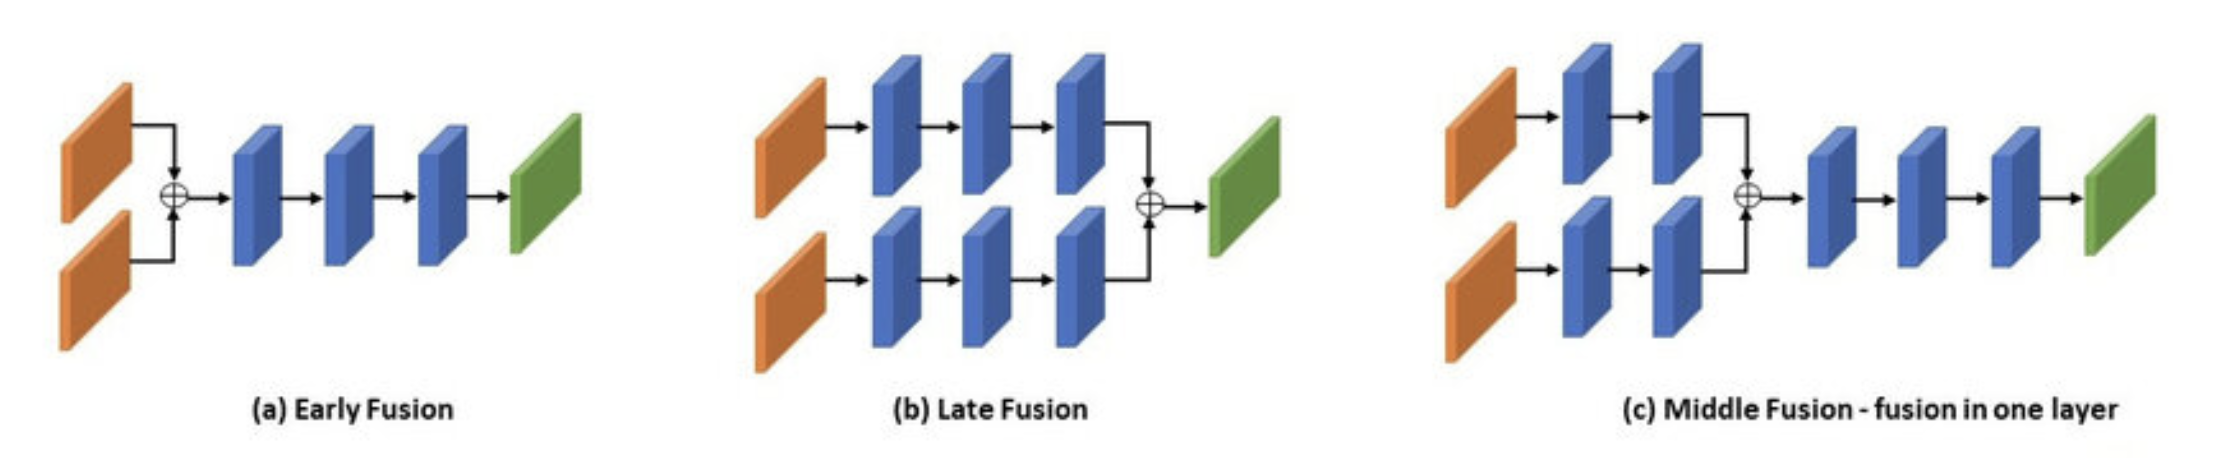


## Deep Embeddings & Flat Fusion (2010–2015)

Modality-Specific Deep Nets: Use RNNs/CNNs to learn embeddings for text, spectrograms for audio, and frame-level CNNs for video.

Flat Fusion: Directly concatenate learned embeddings and fine-tune end-to-end.

Limitation: Single fusion layer struggles to disentangle pairwise modality interactions from full trimodal relationships.

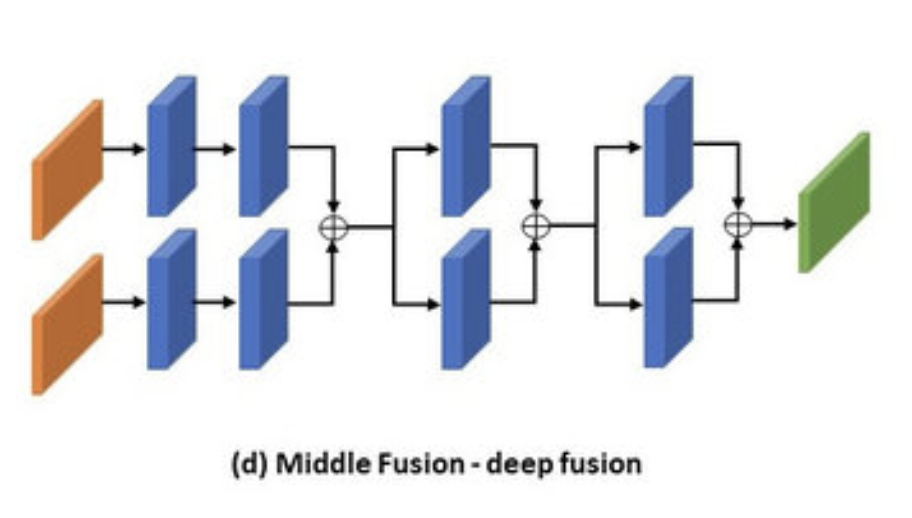

## Attention & Context (2016–2018)

Attention Mechanisms: Learn per-modality or per-feature weights (e.g., Tensor Fusion Network, Zadeh et al., 2017).

Context Modeling: Sequence models (GRU/LSTM) on fused embeddings to capture sentiment evolution.

Hierarchical Fusion (Majumder et al., 2018):

1.   Bimodal Fusion: Pairwise feature fusion blocks.

2.   Trimodal Fusion: Second-stage fusion of the three pairwise outputs.

3.   Context RNN: GRU processes sequence of fused utterance embeddings.







# Unimodal Fusion

1. Textual:
Represent each word with pretrained 300-d Word2Vec vectors.
Pad/truncate utterances to 50 tokens.
Pass through two 1D-CNN layers (filters sizes 3,4 → 50 maps; size 2 → 100 maps), each followed by 2×2 max-pooling.
Penultimate FC layer (500 neurons, ReLU) yields the 500-d textual feature – grows receptive field to capture phrase-level semantics

2. Acoustic:
Frame rate: 30 Hz, 100 ms sliding window.
Extract Low Level Descriptors (pitch, voice intensity) + functionals (mean, std, skewness, quartiles, linear regression slope) via OpenSMILE IS13-ComParE.
Z-normalize voice intensity; threshold non-speech segments.
Total of 6,392 acoustic features per utterance

3. Visual:
Input: raw video tensor (3×f×h×w).
Apply 3D-CNN with filter size (fm=32, fd=5, fh=5, fw=5), stride=1 → max-pool 3×3×3 → dense layer (300 neurons).
Captures spatiotemporal facial/action dynamics.
300-d visual feature per utterance

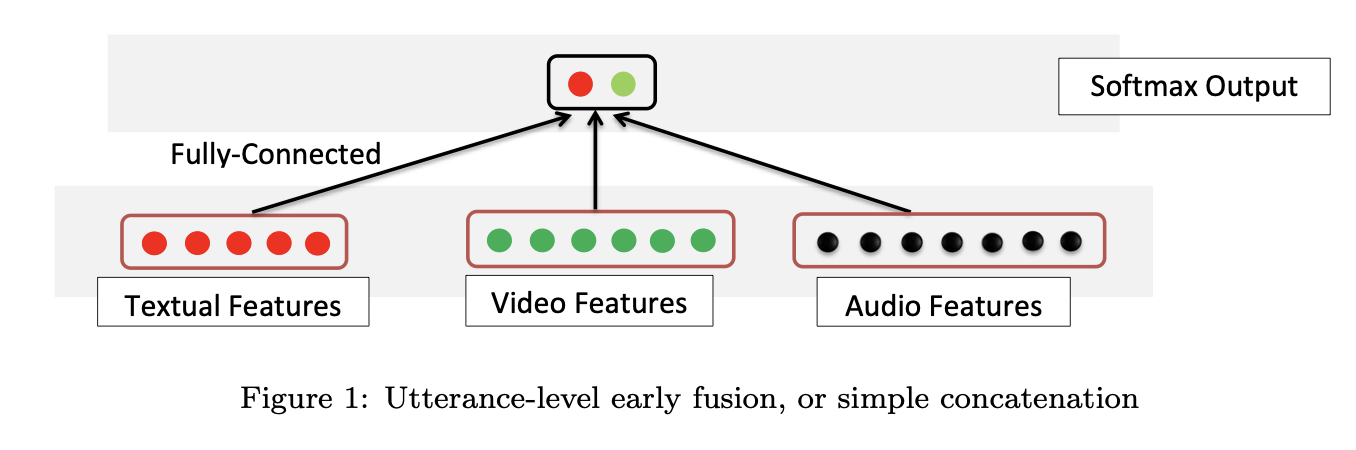

# Fusion Methods

## 1. Bimodal Fusion:

For each modality pair (e.g., Text and Audio), let `f1` and `f2` be their feature vectors.

1. **Concatenation**  
   Combine the two vectors along the feature dimension:

   $$
   \mathbf{f}_{\text{concat}} = [\mathbf{f}_1; \mathbf{f}_2]
   $$

2. **Fully-Connected + ReLU Layer**  
   Pass the concatenated vector through a linear layer followed by ReLU activation:

   $$
   \mathbf{g}_{12} = \text{ReLU}(W \cdot [\mathbf{f}_1; \mathbf{f}_2] + \mathbf{b})
   $$

3. Repeat this process for all three pairs:
   - Text + Audio → **g<sub>TA</sub>**
   - Text + Video → **g<sub>TV</sub>**
   - Audio + Video → **g<sub>AV</sub>**

---


```python
# PyTorch implementation of Bimodal Fusion
import torch
import torch.nn as nn

class BimodalFusion(nn.Module):
    def __init__(self, dim1, dim2, hidden_dim):
        super(BimodalFusion, self).__init__()
        self.fc = nn.Linear(dim1 + dim2, hidden_dim)
        self.relu = nn.ReLU()

    def forward(self, f1, f2):
        combined = torch.cat((f1, f2), dim=-1)
        return self.relu(self.fc(combined))
```

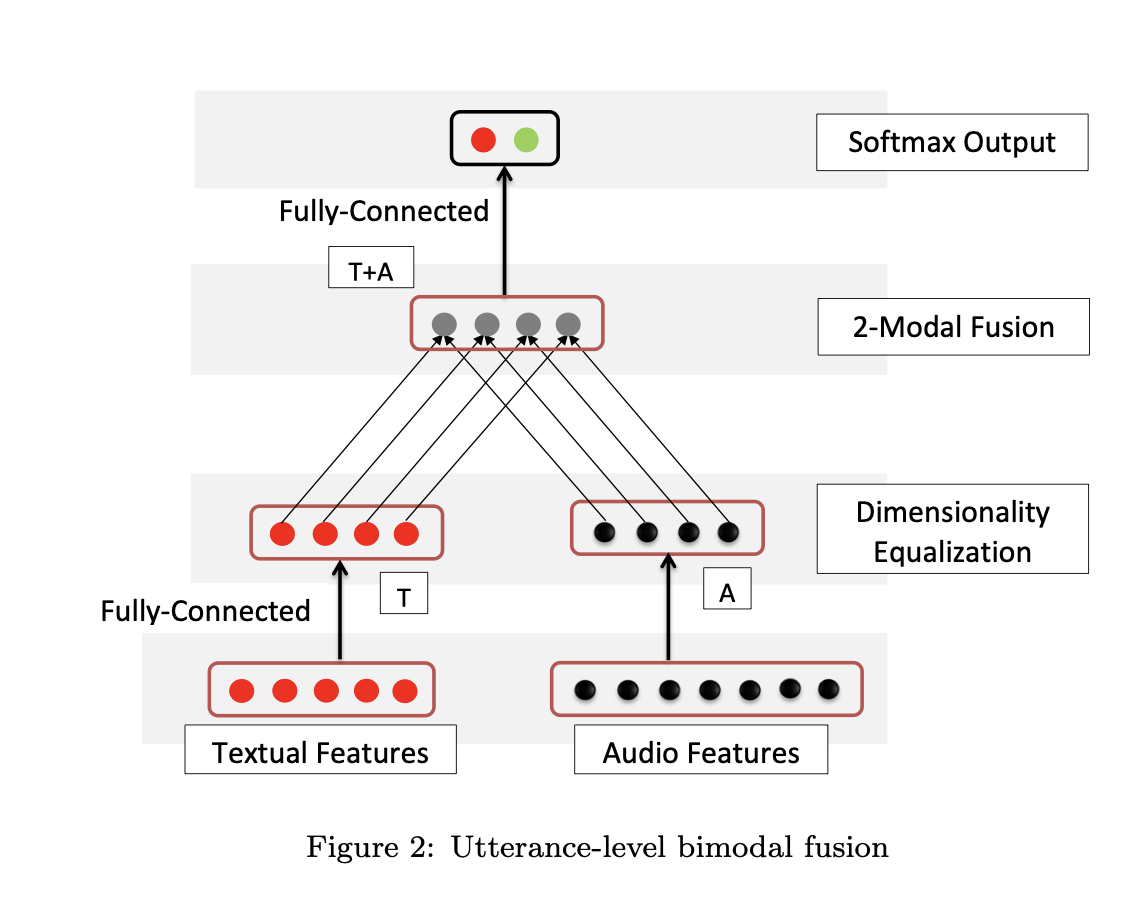

## 2. Trimodal Fusion

Once we have the three bimodal fusion outputs:

- $\mathbf{g}_{TA}$ from Text + Audio  
- $\mathbf{g}_{TV}$ from Text + Video  
- $\mathbf{g}_{AV}$ from Audio + Video

We concatenate them into a single vector:

$$
\mathbf{G} = [\mathbf{g}_{TA}; \mathbf{g}_{TV}; \mathbf{g}_{AV}] \in \mathbb{R}^{3h}
$$

Then we pass this vector through another fully connected layer with ReLU activation:

$$
\mathbf{f}_{\text{trimodal}} = \text{ReLU}(W_2 \cdot \mathbf{G} + \mathbf{b}_2) \in \mathbb{R}^{k}
$$

This **second-stage fusion** enables the model to learn **higher-order interactions across all three modalities**.

---

```python
# PyTorch implementation of Trimodal Fusion
class TrimodalFusion(nn.Module):
    def __init__(self, hidden_dim, output_dim):
        super(TrimodalFusion, self).__init__()
        self.fc = nn.Linear(3 * hidden_dim, output_dim)
        self.relu = nn.ReLU()

    def forward(self, g_ta, g_tv, g_av):
        combined = torch.cat((g_ta, g_tv, g_av), dim=-1)
        return self.relu(self.fc(combined))
```

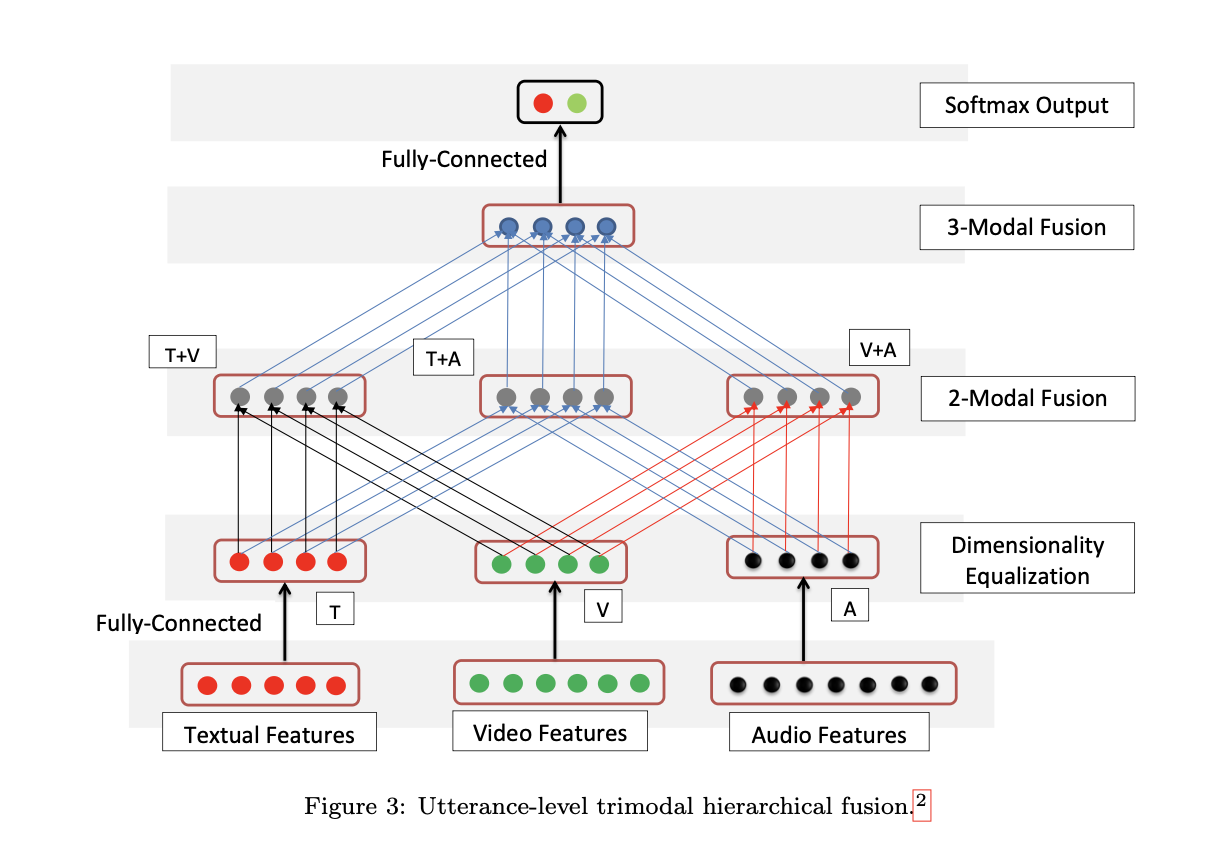


# Addition of Context for Unimodal features

##  Feature Extraction

The model processes input video data at the **utterance level**, extracting aligned **textual**, **audio**, and **visual features** for each segment. This ensures that all three modalities are synchronized temporally and semantically.

---

## Textual Feature Extraction

The transcript of each utterance is first tokenized and converted into word vectors using pretrained Word2Vec embeddings (dimension: 300). Each utterance is padded or truncated to **50 words**.

1. **Word Embedding Matrix**  
   Let the word sequence be:
   $$
   w_1, w_2, \ldots, w_{T} \quad (T \leq 50)
   $$  
   Each word is embedded as:  
   $$
   \mathbf{x}_i = \text{Word2Vec}(w_i) \in \mathbb{R}^{300}
   $$
   
2. **Temporal Convolution**  
   A **1D-CNN** is applied over the word sequence with three parallel filters:
   - Filter sizes: 2, 3, and 4
   - Output feature maps: 100 (size 2), 50 (size 3), 50 (size 4)

3. **Max Pooling & Fully Connected Layer**  
   Apply max-pooling over each filter output, concatenate the pooled vectors, and pass through a fully connected layer with ReLU activation.

4. **Final Output**  
   The final **textual embedding** per utterance:  
   $$
   \mathbf{f}_{\text{text}} \in \mathbb{R}^{500}
   $$

---

###  Audio Feature Extraction

The audio track of each utterance is processed to extract paralinguistic features such as pitch, jitter, and energy variations using the **openSMILE** toolkit.

1. **Frame Sampling**  
   - Frame rate: 30 Hz  
   - Sliding window: 100 ms

2. **Preprocessing**  
   - **Silence Removal:** Discard frames with low voice intensity  
   - **Z-Normalization:** Normalize intensity to mean 0, std 1

3. **Feature Extraction**  
   - Tool: **openSMILE** with IS13-ComParE configuration  
   - Extracts:
     - **Low-Level Descriptors (LLDs):** pitch, shimmer, jitter, etc.  
     - **Statistical Functionals:** mean, std, quartiles, skewness, kurtosis, etc.

4. **Final Output**  
   Each utterance is represented by a **fixed-length vector**:  
   $$
   \mathbf{f}_{\text{audio}} \in \mathbb{R}^{6392}
   $$

---

###  Visual Feature Extraction

Visual features capture facial expressions and gestures from the speaker's face in the video frames.

1. **Input Representation**  
   - Each utterance is a sequence of frames:  
     $$
     \mathcal{V} = \{F_1, F_2, \ldots, F_N\}
     $$
     where each frame $$ F_i \in \mathbb{R}^{H \times W \times 3} $$

2. **3D Convolution**  
   - A 3D-CNN is applied to extract **spatiotemporal features**.  
   - Parameters:
     - Filters: 32  
     - Kernel size: \(5 \times 5 \times 5\)  
     - Stride: 1  
     - Followed by max pooling over \(3 \times 3 \times 3\)

3. **Fully Connected Layer**  
   - Output is flattened and passed through a dense layer with 300 units and ReLU activation.

4. **Final Output**  
   The resulting **visual embedding** per utterance:  
   $$
   \mathbf{f}_{\text{video}} \in \mathbb{R}^{300}
   $$

---

###  Summary of Modal Embeddings

| Modality | Feature Vector | Dimensionality |
|----------|----------------|----------------|
| Text     | $$ \mathbf{f}_{\text{text}} $$     | 500            |
| Audio    | $$ \mathbf{f}_{\text{audio}} $$    | 6,392          |
| Video    | $$ \mathbf{f}_{\text{video}} $$    | 300            |

---
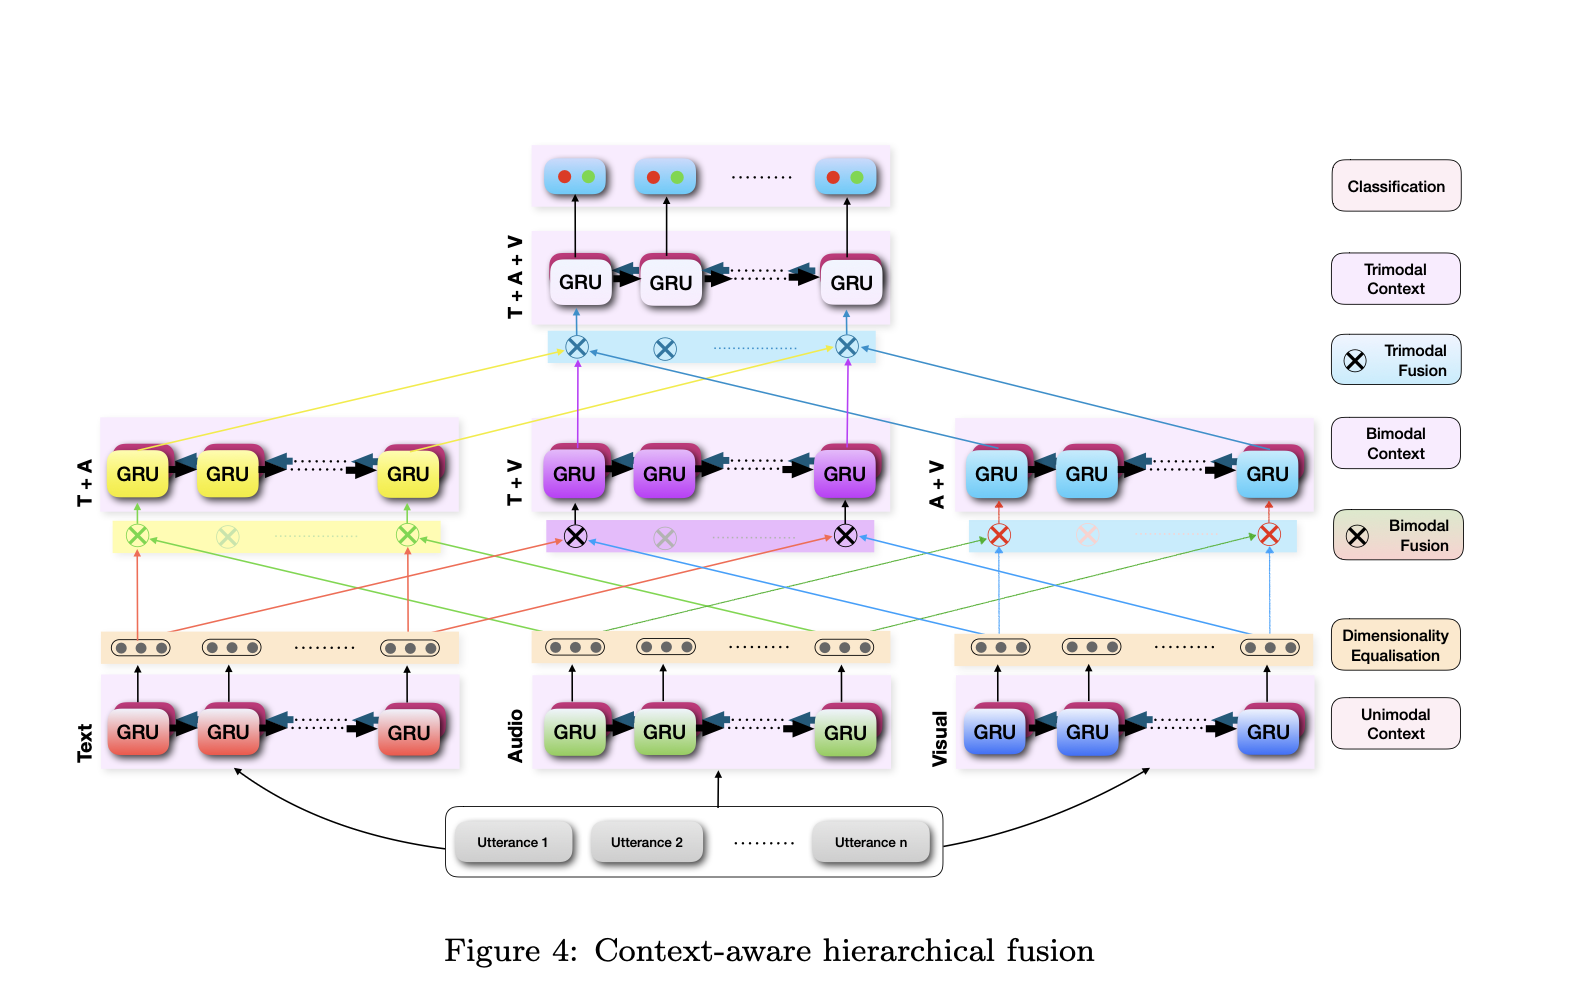



# Multimodal Fusion Overview

After obtaining **context-aware unimodal features**  
$$
\mathbf{F}_A \in \mathbb{R}^{N \times d_A},\quad
\mathbf{F}_V \in \mathbb{R}^{N \times d_V},\quad
\mathbf{F}_T \in \mathbb{R}^{N \times d_T},
$$

we map each to a common **abstract feature space** of dimension \(D\) before any fusion.

## Dimensionality Equalization

For each modality \(x \in \{A,\,V,\,T\}\), apply a fully-connected layer + \(\tanh\):
$$
\mathbf{g}_x = \tanh\bigl(\mathbf{F}_x \mathbf{W}_x + \mathbf{b}_x\bigr)
\quad
\in \mathbb{R}^{N \times D}
$$
where
- $$\mathbf{W}_A\!\in\!\mathbb{R}^{d_A\times D},\;\mathbf{b}_A\!\in\!\mathbb{R}^{D}$$
- $$\mathbf{W}_V\!\in\!\mathbb{R}^{d_V\times D},\;\mathbf{b}_V\!\in\!\mathbb{R}^{D}$$
- $$\mathbf{W}_T\!\in\!\mathbb{R}^{d_T\times D},\;\mathbf{b}_T\!\in\!\mathbb{R}^{D}$$

## Bimodal Fusion

Compare & combine each pair of abstract features element-wise:

For each time-step \(t\) and feature index \(l\):
$$
\begin{aligned}
i^{(l)}_{VA,t} &= \tanh\bigl(w^{(l)}_{VA}\,[g^{{(l)}}_{V,t},\,g^{{(l)}}_{A,t}]^T + b^{(l)}_{VA}\bigr),\\
i^{(l)}_{AT,t} &= \tanh\bigl(w^{(l)}_{AT}\,[g^{{(l)}}_{A,t},\,g^{{(l)}}_{T,t}]^T + b^{(l)}_{AT}\bigr),\\
i^{(l)}_{VT,t} &= \tanh\bigl(w^{(l)}_{VT}\,[g^{{(l)}}_{V,t},\,g^{{(l)}}_{T,t}]^T + b^{(l)}_{VT}\bigr).
\end{aligned}
$$


Collecting over $$l=1\ldots D$$ Gives three bimodal sequences  
$$ \mathbf{f}_{VA},\,\mathbf{f}_{AT},\,\mathbf{f}_{VT}\in\mathbb{R}^{N\times D}$$

## Context-Aware Bimodal Features

Pass each bimodal sequence through its own GRU to inject temporal context:

$$
\mathbf{F}_{VA} = \mathrm{GRU}_{VA}\bigl(\mathbf{f}_{VA}\bigr),\quad
\mathbf{F}_{AT} = \mathrm{GRU}_{AT}\bigl(\mathbf{f}_{AT}\bigr),\quad
\mathbf{F}_{VT} = \mathrm{GRU}_{VT}\bigl(\mathbf{f}_{VT}\bigr).
$$

Each $$\mathbf{F}_{*}\in\mathbb{R}^{N\times D_2}$$ is now context-aware.

## Trimodal Fusion

Combine the three context-aware bimodal vectors at each \(t\), again element-wise:

For $$l=1\ldots D_2$$
$$
z^{(l)}_t
= \tanh\bigl(w^{(l)}_{AVT}\,[F^{(l)}_{VA,t},\,F^{(l)}_{AT,t},\,F^{(l)}_{VT,t}]^T + b^{(l)}_{AVT}\bigr).
$$

This yields
$$\mathbf{f}_{AVT}\in\mathbb{R}^{N\times D_2}$$

## Context-Aware Trimodal Features

Finally, apply a GRU over the trimodal sequence to get the **ultimate** context-aware features:

$$
\mathbf{F}_{AVT} = \mathrm{GRU}_{AVT}\bigl(\mathbf{f}_{AVT}\bigr),
\quad
\mathbf{F}_{AVT}\in\mathbb{R}^{N\times D_3}.
$$


## Classification

Feed each time-step of \(\mathbf{F}_{AVT}\) into a softmax layer for binary sentiment:

$$
\mathbf{p}_t = \mathrm{softmax}\bigl(\mathbf{W}_{\text{soft}}\;\mathbf{F}_{AVT,t} + \mathbf{b}_{\text{soft}}\bigr),
\quad
\hat{y}_t = \arg\max_j\,p_{t,j}.
$$
Training uses **categorical cross-entropy** and Adam optimizer.

# Dataset Details

All experiments use the **CMU-MOSI** dataset:

| Attribute               | Detail                                                             |
|-------------------------|--------------------------------------------------------------------|
| **Videos**              | 93 YouTube review clips                                            |
| **Utterances**          | 2,199 annotated segments                                           |
| **Modalities**          | Text (transcripts), Audio (OpenSMILE eGeMAPS), Video (3D-CNN/ResNet) |
| **Sentiment Labels**    | Continuous –3 to +3 (binarized at 0)                               |
| **Train/Val/Test Split**| 1,014 / 229 / 936 utterances    


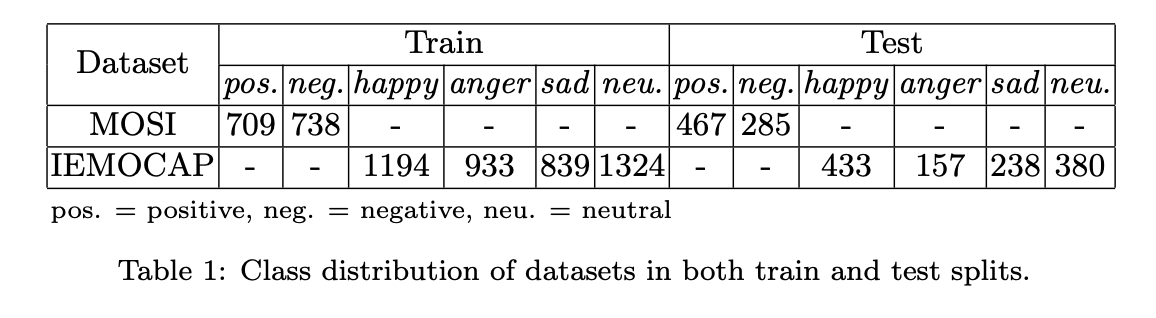

### ▶️ CMU-MOSI

- **Description:** Short opinion clips (e.g. movie/product reviews) collected from YouTube.
- **Utterance Segmentation:** 2,199 segments manually annotated.
- **Modalities:**
  - **Text:** Human transcripts, pretrained Word2Vec embeddings.
  - **Audio:** 6,392 OpenSMILE eGeMAPS features per utterance.
  - **Video:** 300-D ResNet-50 / 3D-CNN frame embeddings.
- **Labels:**  
  Continuous sentiment scores ∈ [–3, +3] averaged over 5 annotators and binarized at 0.  
- **Speaker-Independent Split:**  
  - **Train/Val:** First 62 speakers (1,014 train, 229 val)  
  - **Test:** Remaining 31 speakers (936 utt.)  

---

### ▶️ IEMOCAP

- **Description:** Dyadic conversational sessions with professional actors.
- **Utterance Count:** ~10,000 total; we use the four primary emotions.
- **Modalities:**
  - **Text:** Transcripts of utterances, Word2Vec + CNN encoding.
  - **Audio:** OpenSMILE eGeMAPS features.
  - **Video:** 3D-CNN spatiotemporal embeddings.
- **Labels:**  
  Four emotion categories: *Anger, Happy, Sad, Neutral*.
- **Cross-Speaker Split:**  
  - **Train:** Sessions from 8 speakers  
  - **Test:** Sessions from 2 held-out speakers  

---

### 🔍 Class Distribution

```python
# Example: Visualize positive vs. negative in CMU-MOSI (you can run this in Colab)
import pandas as pd
import matplotlib.pyplot as plt

data = {'Class': ['Positive', 'Negative'],
        'Count': [sum(labels > 0), sum(labels <= 0)]}
df = pd.DataFrame(data)
df.plot.bar(x='Class', y='Count', legend=False)
plt.title('CMU-MOSI Sentiment Distribution')
plt.ylabel('Number of Utterances')


##  Core Algorithms (Pseudocode)

Below is a high-level pseudocode summary of the **Context-Aware Hierarchical Fusion** training and inference steps, adapted from Algorithm 1 in the paper.

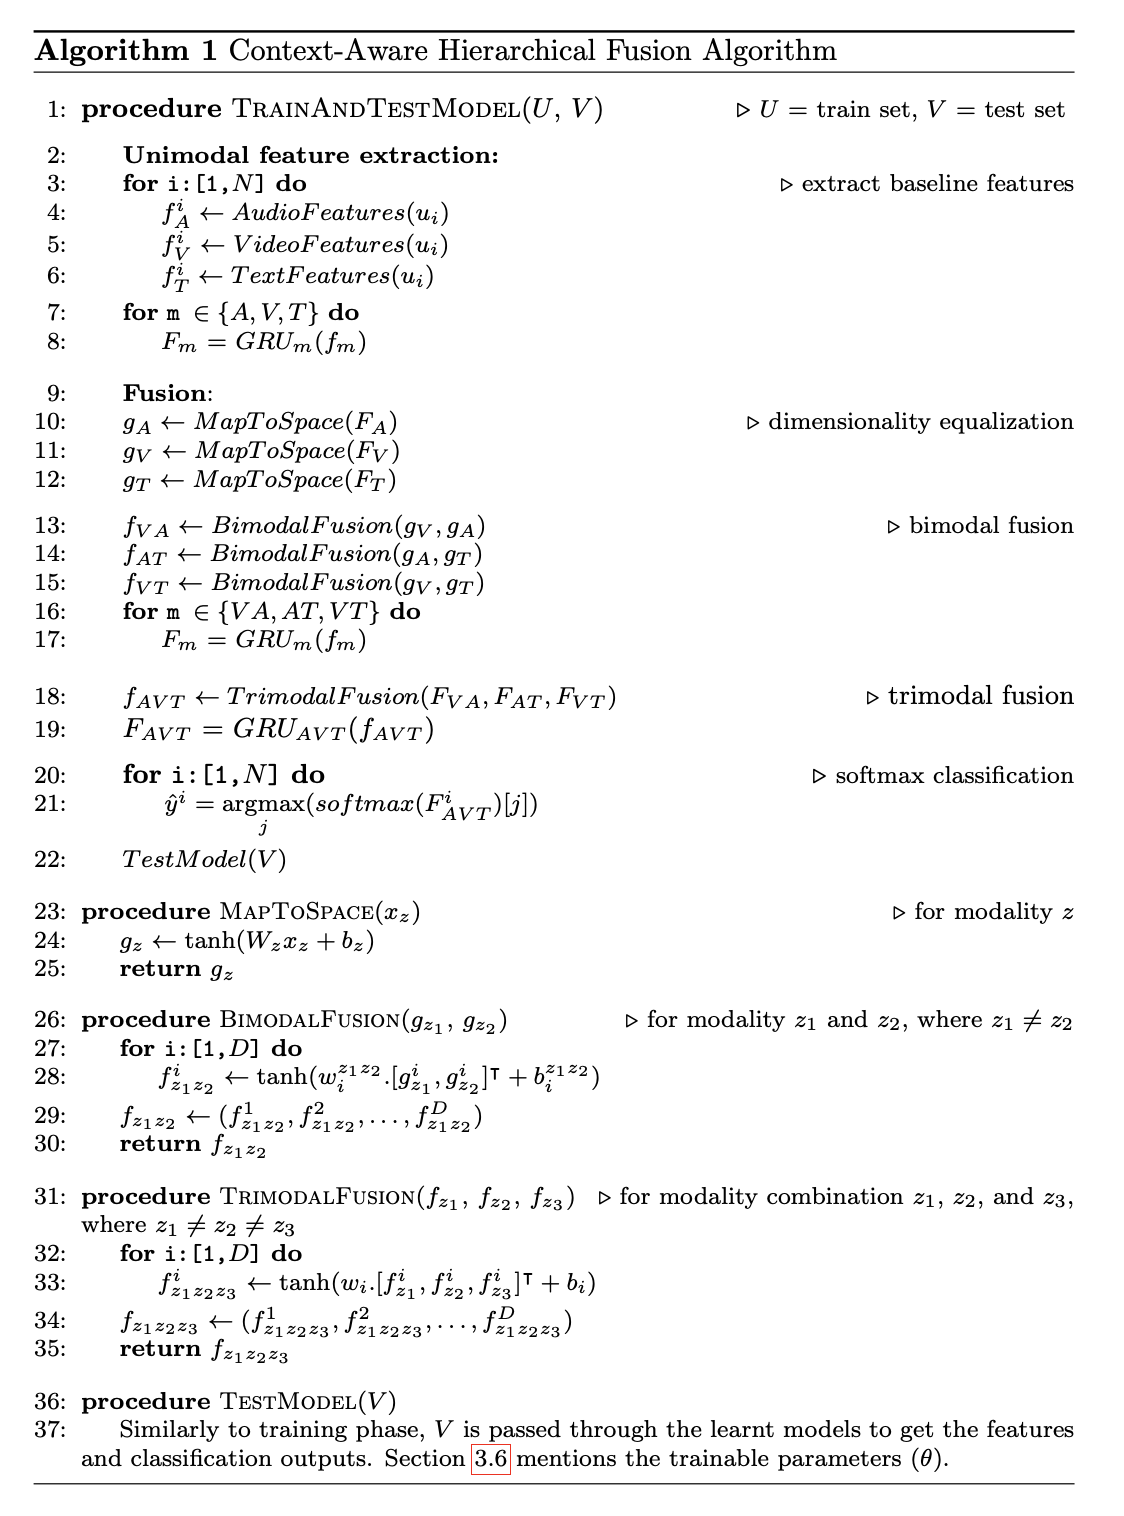

## Results: Hierarchical Fusion (No Context)

**Table 2:** Comparison of **Hierarchical Fusion (HFusion)** against baselines on **CMU-MOSI**  
(“SOTA1” = Poria et al. [43], “SOTA2” = Zadeh et al. [44])

| Modality Combo | SOTA1 Acc | SOTA2 Acc | Early Fusion Acc | HFusion Acc |
|---------------:|:---------:|:---------:|:----------------:|:-----------:|
| T              |    —      |  75.0%    |       77.1%      |    77.8%    |
| V              |    —      |  55.3%    |       56.5%      |    56.9%    |
| A              |    —      |  56.9%    |       56.1%      |    57.5%    |
| T + V          |  73.2%    |  73.8%    |       77.1%      |    77.4%    |
| T + A          |  73.2%    |  73.5%    |       77.1%      |    77.3%    |
| A + V          |  55.7%    |  56.2%    |       56.5%      |    56.8%    |
| T + A + V      |  73.5%    |  71.2%    |       77.0%      |    77.9%    |


## Results: Context-Aware Hierarchical Fusion (CHFusion)

**Table 3:** Accuracy (Acc) and F1-Scores (IEMOCAP) for **Context-Aware Hierarchical Fusion**  
(“SOTA1” = Poria et al. [43], “SOTA2” = Zadeh et al. [44])

| Modality Combo | CMU-MOSI SOTA1 | CMU-MOSI SOTA2 | CHFusion Acc | IEMOCAP SOTA1 | IEMOCAP SOTA2 | CHFusion Acc | CHFusion F1 |
|---------------:|:--------------:|:--------------:|:------------:|:-------------:|:-------------:|:------------:|:-----------:|
| T              |    76.5%       |    73.6%       |   79.3%      |      —        |      —        |     —        |     —       |
| V              |    54.9%       |    53.3%       |   58.8%      |      —        |      —        |     —        |     —       |
| A              |    55.3%       |    57.1%       |   58.8%      |      —        |      —        |     —        |     —       |
| T + V          |    77.8%       |    77.1%       |   79.3%      |    74.1%      |    73.7%      |   75.9%      |   75.6%     |
| T + A          |    77.3%       |    77.0%       |   79.1%      |    73.7%      |    71.1%      |   76.1%      |   76.0%     |
| A + V          |    57.9%       |    56.5%       |   58.8%      |    68.4%      |    67.4%      |   69.5%      |   69.6%     |
| T + A + V      |    78.7%       |    77.2%       | **80.0%**    |    74.1%      |    73.6%      |   76.5%      |   76.8%     |


## Comparative Analysis & Key Observations

After evaluating our **Context‐Aware Hierarchical Fusion** (CHFusion) model against prior work and baselines, we make the following observations:

---

### 1. Outperforming MKL-Based Fusion

> “Our model outperformed which employed Multiple Kernel Learning (MKL), for **all** bimodal and trimodal combinations by **1–1.8%**.”

- **Inference 1:** The **unimodal features** we extract (text CNN, OpenSMILE audio, 3D‐CNN video) are more discriminative.  
- **Inference 2:** Our **hierarchical fusion** mechanism (bimodal → trimodal) captures inter‐modal correlations more effectively than MKL’s concatenation + kernel‐based approach.

---

### 2. Multimodal > Unimodal

> “Consistent with the literature, multimodal classifiers outperform unimodal ones.”

- **Unimodal Results:**  
  - **Text only:** ~75% accuracy  
  - **Audio only:** ~56–58%  
  - **Video only:** ~55–57%  
- **Multimodal Gains:**  
  - Adding audio &/or video to text yields **+2–5%** improvement.  
  - **Trimodal (T+A+V):** Highest accuracy across all setups.

---

### 3. Hierarchical vs. Early Fusion

> “Compared to early (flat) concatenation, hierarchical fusion consistently achieves better performance for every modality combination.”

- **Early Fusion Limitation:** Treats all modalities equally with a single FC layer.  
- **Hierarchical Advantage:**  
  1. Pairwise fusion filters out conflicting signals.  
  2. Trimodal stage refines only those signals that survive bimodal consensus.  
- **Example Insight:**  
  - Early fusion yields identical scores for **T+V** and **T+A**.  
  - Our method shows **T+V > T+A**, aligning with the fact that facial cues often carry richer emotional nuance than voice alone.

---

### 4. Tensor Fusion Network Comparison

> “Although Tensor Fusion Network (TFN) models full outer‐product correlations, it has **no learnable parameters** in the fusion step.”

- **TFN Drawback:** Relies on a fixed outer product—cannot adapt weighting of bimodal vs. trimodal interactions.  
- **Our Benefit:** Fully‐connected fusion layers **learn** optimal weights for each pair or trio of modalities (Equations (1)–(3)), leading to consistent gains over TFN across all evaluated scenarios.

---

### 5. Textual Modality Dominance

- **Strongest Unimodal:** Text achieves ~75% accuracy on CMU-MOSI, ~76% on IEMOCAP.  
- **Marginal Contribution of Other Modalities:**  
  - Audio & video each add ~2–4% when fused with text.  
  - Alone, they hover near majority‐class baselines.

---

### 6. Contextual Modeling Impact

- **HFusion vs. CHFusion:**  
  - Adding GRU‐based context to HFusion brings an extra **1–2%** accuracy boost across CMU-MOSI and IEMOCAP.  
  - Confirms that **temporal dependencies** (utterance sequences) are valuable for sentiment/emotion classification.

---

### Takeaways

1. **Feature Quality Matters:** Robust unimodal embeddings are the foundation for strong multimodal performance.  
2. **Hierarchical Fusion** outperforms both flat concatenation and fixed‐fusion tensors by learning stage‐wise correlations.  
3. **Context Modeling** (GRUs) further enhances performance, especially in dialogue or multi‐utterance settings.  
4. **Text Remains King:** Despite multimodal gains, text provides the single biggest signal; however, combining audio/video yields the best overall results.  

---  


##  Conclusion

In this work, we introduced a **Context‐Aware Hierarchical Fusion** framework for multimodal sentiment analysis that:

1. **Extracts** rich unimodal features from text (CNN + Word2Vec), audio (openSMILE eGeMAPS), and video (3D‐CNN).  
2. **Applies** GRU-based context modeling at the unimodal, bimodal, and trimodal levels to capture temporal dependencies across utterances.  
3. **Fuses** modalities in a **two‐stage hierarchy**—first pairwise (bimodal), then all three (trimodal)—with learnable fully‐connected layers.  
4. **Outperforms** state‐of‐the‐art baselines (MKL, Tensor Fusion Network , early fusion) by **1–2.4%** on CMU‐MOSI and IEMOCAP.  

Key strengths of our approach include its modularity (easy to plug in new modalities), its ability to learn optimal correlation weights at each fusion stage, and its demonstrable gains from sequence‐level context. Future directions involve exploring transformer‐based context layers, self‐supervised pretraining on large multimodal corpora, and extending to fine‐grained emotion taxonomies.

---

##  References

1. **Majumder, N.**, Hazarika, D., Gelbukh, A., Cambria, E., & Poria, S. (2018). *Multimodal Sentiment Analysis using Hierarchical Fusion with Context Modeling*. arXiv:1806.06228  
2. **Poria, S.**, Chaturvedi, I., Cambria, E., & Hussain, A. (2016). *Convolutional MKL based multimodal emotion recognition and sentiment analysis*. ICDM.  
3. **Zadeh, A.**, Chen, M., Poria, S., Cambria, E., & Morency, L.-P. (2017). *Tensor Fusion Network for Multimodal Sentiment Analysis*. EMNLP.  
4. **Poria, S.**, Cambria, E., Hazarika, D., et al. (2017). *Context-dependent sentiment analysis in user-generated videos*. ACL.  
5. Eyben, F., Wöllmer, M., & Schuller, B. (2010). *openSMILE – The Munich versatile and fast open-source audio feature extractor*. ACM Multimedia.  
6. Ji, S., Xu, W., Yang, M., & Yu, K. (2013). *3D convolutional neural networks for human action recognition*. IEEE TPAMI.  
7. Vaswani, A., et al. (2017). *Attention Is All You Need*. NIPS.  
8. Poria, S., Cambria, E., Gelbukh, A., Thelwall, M. (2017). *Sentiment Analysis is a Big Suitcase*. IEEE Intelligent Sys
